In [70]:
import numpy as np

experiment_configs = [{"device_name": ["GeForce GTX TITAN Black"],
                        "f_name": ["f_layer_complex_neuron_local"],
                        "n_neurons_l0": np.arange(32, 1024, 32),
                        "n_inputs": np.arange(32, 1888, 32),
                        "mults_per_thread": [1],
                        "neurons_per_wrg": [0]},
                      {"device_name": ["GeForce GTX TITAN Black"],
                        "f_name": ["f_layer_complex_neuron_mrgd_wrgs_in_1d"],
                        "n_neurons_l0": np.arange(32, 1024, 32),
                        "n_inputs": np.arange(32, 1888, 32),
                        "mults_per_thread": [1],
                        "neurons_per_wrg": [0]},
                      {"device_name": ["GeForce GTX TITAN Black"],
                        "f_name": ["f_layer_complex_neuron_mrgd_wrgs_in_2d"],
                        "n_neurons_l0": np.arange(32, 1024, 32),
                        "n_inputs": np.arange(32, 1888, 32),
                        "mults_per_thread": [1],
                        "neurons_per_wrg": [1]},
                      {"device_name": ["GeForce GTX TITAN Black"],
                        "f_name": ["f_layer_complex_neuron_mrgd_wrgs_in_2d_coalesced"],
                        "n_neurons_l0": np.arange(32, 1024, 32),
                        "n_inputs": np.arange(32, 1888, 32),
                        "mults_per_thread": [1],
                        "neurons_per_wrg": [1]},
                      {"device_name": ["GeForce GTX TITAN Black"],
                        "f_name": ["f_layer_complex_neuron_mrgd_wrgs_in_2d"],
                        "n_neurons_l0": np.arange(32, 1024, 32),
                        "n_inputs": np.arange(32, 1888, 32),
                        "mults_per_thread": [2],
                        "neurons_per_wrg": [2]},
                      {"device_name": ["GeForce GTX TITAN Black"],
                        "f_name": ["f_layer_complex_neuron_mrgd_wrgs_in_2d_coalesced"],
                        "n_neurons_l0": np.arange(32, 1024, 32),
                        "n_inputs": np.arange(32, 1888, 32),
                        "mults_per_thread": [2],
                        "neurons_per_wrg": [2]}]
def get(key, arr):
    return np.asarray([dict_el[key] for dict_el in arr])

In [71]:
import os
import pprint
import pandas as pd

def load_experiments():
    #experiment_dir = "experiment." + network_config
    results_lift = None
    i = 0
    for experiment_dir in filter(
        lambda x: os.path.isdir(os.path.join(".", x)) and 
        x.startswith("experiment.") and 
        os.path.isdir(os.path.join(".", x, "results_lift")), 
        os.listdir(".")):
        results_lift_dir = os.path.join(".", experiment_dir, "results_lift")

        for filename in os.listdir(results_lift_dir):
            single_csv = pd.read_csv(os.path.join(results_lift_dir, filename), index_col=False)
            single_csv["datetime"] = filename[:filename.find("_")]
            single_csv["n_neurons_l0"] = int(experiment_dir[15:experiment_dir.find("-", 15)])
            if results_lift is not None:
                results_lift = results_lift.append(single_csv, ignore_index=True)                
            else:
                results_lift = single_csv
            i = i + 1
            if i % 20 == 0:
                print(".", end="")
    print()
    return results_lift

def matches(result, config):
    for (key, allowed_values) in config.items():
        if key in result and (
            (isinstance(result[key], float) and result[key] in allowed_values) or
            (isinstance(result[key], str) and result[key] in 
                 [value.replace("\x00","") for value in allowed_values])):
            next
        else:
            return False
    return True

def filter_experiments(experiment_configs, nonfiltered_results):
    results = []
    for config in experiment_configs:
        results.append(nonfiltered_results[np.all([
                        nonfiltered_results[k].isin(vs) for k, vs in config.items()], axis=0)])
        #results.append([result for result in nonfiltered_results if matches(result, config)])
    return results

nonfiltered_results = load_experiments()
print("%d non-filtered results." % len(nonfiltered_results))

................................................................................................................................................................................................................................................................................................................
6086 non-filtered results.


In [72]:
results = filter_experiments(experiment_configs, nonfiltered_results)
data_is_reset = True

print("Loaded " + str(len(results)) + " experiment(s):")
for exp_i in range(len(results)):
    print("Experiment " + str(exp_i) + ": " + str(len(results[exp_i])) + " records")

Loaded 6 experiment(s):
Experiment 0: 1021 records
Experiment 1: 802 records
Experiment 2: 801 records
Experiment 3: 800 records
Experiment 4: 716 records
Experiment 5: 716 records


In [73]:
# Format data
if data_is_reset:
    # Runtimes: s -> ms
    original_status = pd.options.mode.chained_assignment
    pd.options.mode.chained_assignment = None
    for result in results:
        result.loc[:, "runtime_l0"] = result["runtime_l0"].apply(lambda x: x * 1000)
        result.loc[:, "runtime_l1"] = result["runtime_l1"].apply(lambda x: x * 1000)
        result.loc[:, "runtime_l2"] = result["runtime_l2"].apply(lambda x: x * 1000)
    pd.options.mode.chained_assignment = original_status
    print ("Data was formatted.")
    data_is_reset = False

Data was formatted.


In [74]:
def ipnps(df):
    if df.empty:
        return 0
    else:
        #return df["runtime_l0"]
        #return df["n_inputs"] / (df["layer_len0"] * df["runtime_l0"])
        #return df["runtime_l0"] / (df["n_inputs"] * df["layer_len0"])
        return (df["n_inputs"] * df["layer_len0"]) / df["runtime_l0"]
    
def standardize(matrices):    
    global_max = 0
    global_min = 999
    print(matrices[0][0])
    for i in range(len(matrices)):
        if matrices[i].max() > global_max:
            global_max = matrices[i].max()
        if matrices[i].min() < global_min:
            global_min = matrices[i].min()
    for i in range(len(matrices)):
        matrices[i] = (matrices[i] - global_min) / (global_max - global_min)
    print(matrices[0][0])
    return matrices

In [75]:
# Prepares data

matrices = []
n_n_neurons = int(1024 / 32 - 1)
n_n_inputs = int(1056 / 32 - 1)
for experiment in results:
    matrix = np.zeros((n_n_neurons, n_n_inputs), dtype=np.float32)
    for n_neurons in np.arange(n_n_neurons):
        for n_inputs in np.arange(n_n_inputs):
            matrix[n_neurons, n_inputs] = np.nan_to_num(
                experiment[(experiment["layer_len0"] == 32 + n_neurons * 32) &
                           (experiment["n_inputs"] == 32 + n_inputs * 32)]\
                [["n_inputs", "layer_len0", "runtime_l0"]]\
                .apply(ipnps, axis=1).mean())
            #print(".", end="")

    #print(matrix[192 / 32, 128 / 32], "----------------")
    matrices.append(matrix)
    
matrices = standardize(matrices)

for i in range(len(matrices)):   
    print()
    matrix2 = np.zeros((matrices[i].shape[0] + 1, matrices[i].shape[1] + 1))
    matrix2[1:, 1:] = matrices[i][:, :]
    matrices[i] = matrix2#.transpose()
    print("Matrix shape:", matrix.shape)
    print("Data prepared.")

[ 0.17621672  0.20451364  0.20475194  0.2050986   0.20486769  0.2054327
  0.20554319  0.20575692  0.205929    0.20598038  0.20637167  0.20597559
  0.20608999  0.20645244  0.20651989  0.20650575  0.20633946  0.20657147
  0.20640709  0.21352504  0.22138694  0.21632314  0.22317906  0.21755449
  0.20783432  0.21296194  0.21970227  0.21605723  0.21684766  0.21786432
  0.20709999  0.21654898]
[ 0.01572851  0.0182542   0.01827547  0.01830641  0.0182858   0.01833623
  0.01834609  0.01836517  0.01838053  0.01838511  0.01842004  0.01838469
  0.0183949   0.01842725  0.01843327  0.01843201  0.01841716  0.01843787
  0.0184232   0.01905852  0.01976025  0.01930827  0.01992021  0.01941818
  0.01855059  0.01900826  0.01960988  0.01928454  0.01935509  0.01944583
  0.01848505  0.01932843]

Matrix shape: (31, 32)
Data prepared.

Matrix shape: (31, 32)
Data prepared.

Matrix shape: (31, 32)
Data prepared.

Matrix shape: (31, 32)
Data prepared.

Matrix shape: (31, 32)
Data prepared.

Matrix shape: (31, 32)


f_layer_complex_neuron_local
Second min: 0.016
Max: 0.016
Mean: 0.017
Median: 0.022

f_layer_complex_neuron_mrgd_wrgs_in_1d
Second min: 0.128
Max: 0.128
Mean: 0.105
Median: 0.148

f_layer_complex_neuron_mrgd_wrgs_in_2d
Second min: 0.243
Max: 0.243
Mean: 0.186
Median: 0.266

f_layer_complex_neuron_mrgd_wrgs_in_2d_coalesced
Second min: 0.243
Max: 0.243
Mean: 0.186
Median: 0.268

f_layer_complex_neuron_mrgd_wrgs_in_2d
Second min: 0.729
Max: 0.729
Mean: 0.601
Median: 0.836

f_layer_complex_neuron_mrgd_wrgs_in_2d_coalesced
Second min: 0.714
Max: 0.714
Mean: 0.588
Median: 0.818



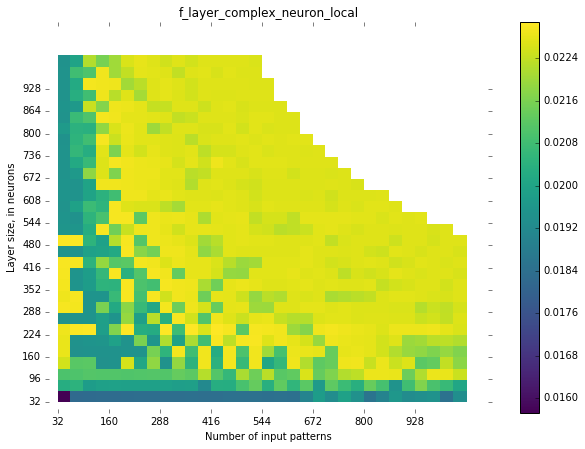

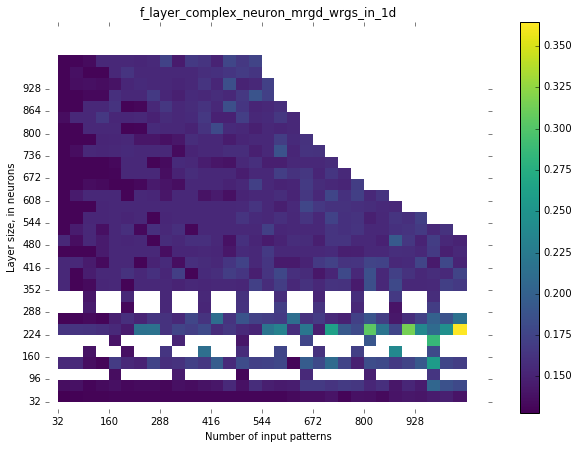

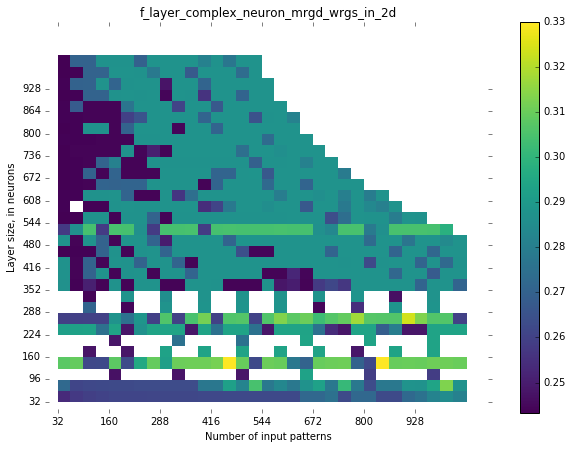

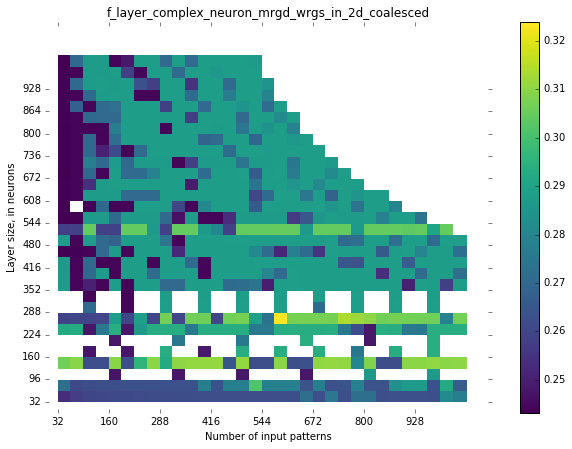

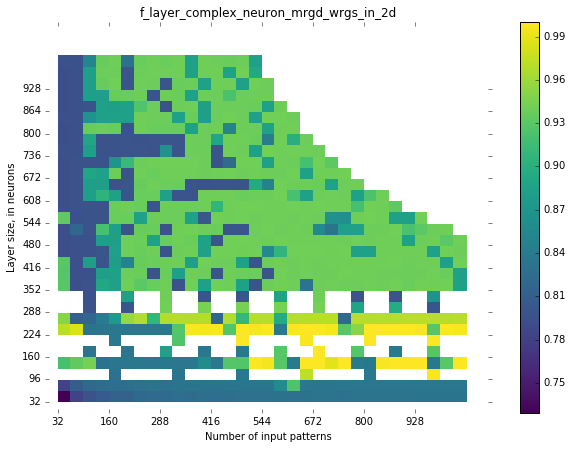

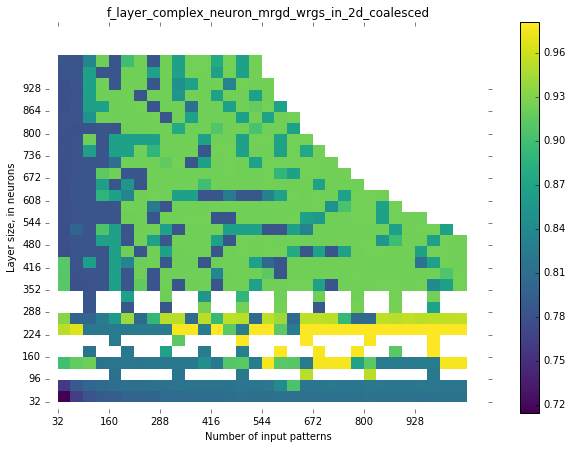

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

second_min_global = 2
for matrix in matrices:
    matrix2 = np.copy(matrix)
    np.place(matrix2, matrix2 == 0, [2])
    second_min = matrix2.min()
    if second_min < second_min_global:
        second_min_global = second_min
    
i = 0
for matrix in matrices:
    matrix2 = np.copy(matrix)
    np.place(matrix2, matrix2 == 0, [2])
    second_min = matrix2.min()
    # Renders the plot
    fig, ax = plt.subplots()
    cmap = plt.cm.viridis
    heatmap = ax.pcolor(matrix, cmap=cmap, vmin=second_min, vmax=matrix.max())
    m = plt.cm.ScalarMappable(cmap=cmap)
    cmap.set_under(color="white")
    m.set_clim(vmin=second_min, vmax=matrix.max())
    m.set_array(matrix)
    plt.colorbar(m)

    ax.set_title(experiment_configs[i]["f_name"][0])
    ax.set_xlabel('Number of input patterns')
    ax.set_ylabel('Layer size, in neurons')
    ax.set_xticks(np.arange(1, n_n_inputs, 4))
    ax.set_xticklabels(np.arange(32, 1056, 32 * 4))
    ax.set_yticks(np.arange(1, n_n_neurons, 2))
    ax.set_yticklabels(np.arange(32, 1024, 32 * 2))

    # Format
    fig = plt.gcf()
    fig.set_size_inches(10, 7)
    # turn off the frame
    ax.set_frame_on(False)
    print(experiment_configs[i]["f_name"][0])
    print("Second min: %.3f" % second_min)
    print("Max: %.3f" % second_min)
    print("Mean: %.3f" % np.mean(matrix))
    print("Median: %.3f" % np.median(matrix))
    print()
    i = i + 1

In [77]:
for matrix in matrices:
    print(matrix[128 / 32, 192 / 32])
print()
for experiment in results:
    print(experiment[(experiment["layer_len0"] == 128) & (experiment["n_inputs"] == 192)]\
        [["n_inputs", "layer_len0", "runtime_l0"]]\
                    .apply(ipnps, axis=1).mean())

0.022610841319
0.154467791319
0.262654334307
0.262659370899
0.836353361607
0.81996512413

0.253323975244
1.73060307038
2.94268728559
2.94274366303
9.37021023494
9.18660287081


/home/nm/.conda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
